# 0005.0000 Modeling - Calibrated Classifiers

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    ├── good-calibration-model.joblib
    └── optimized-model.joblib

16 directories, 11 files


## 6. Select, Impute, Compress the Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

#### Nomenclature

+ base_feature - ftGoals, htGoals, ...
+ feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
+ feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
# selected_base_features = ['ftGoals', 'htGoals', 'shots']#  base_features
# selected_base_features = ['impliedWin', 'impliedDraw',  'impliedLose', 'poissWin', 'poissDraw', 'poissLose']#  base_features
# selected_base_features = ['redCards', 'yellowCards']#  base_features
# selected_base_features = ['corners', 'fouls']#  base_features
# selected_base_features = ['poissWin', 'poissDraw', 'poissLose']
#                           'impliedWin', 'impliedDraw', 'impliedLose',
#                          'ftGoals', 'htGoals', 'shots']#  base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shotsOnTarget-8,h

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=2
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,5.00,6.10,5.19,0.275,0.275,0.45,3.75,3.65,3.75,3.52,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.60,1.70,1.63,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.507860,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,1.90,2.15,2.04

In [9]:
df_cut.shape

(2629, 183)

In [10]:
print(sum(df_cut.columns.duplicated()))

0


### Compress Feature Space

In [11]:
df_compress = df_cut.copy(deep=True)

def compress_all_features(df_orig, func='mean'):
    df = df_orig.copy(deep=True)
    feature_name_stubs = get_feature_name_stubs_from_base(df, selected_base_features)
    for feature_name_stub in feature_name_stubs:
        cols = [col for col in df.columns if '-' in col and feature_name_stub == col.rsplit('-',1)[0]]
        df[feature_name_stub + '-agg'] = df[cols].agg(func=func, axis=1)
        df.drop(columns = cols, inplace=True)
    return df

def drop_unused_features(df_orig):
    df = df_orig.copy(deep=True)
    redundant_features = [col for col in df.columns if 'agg' not in col and (col[0:2] =='h_' or col[0:2] == 'a_')]
    df.drop(columns=redundant_features, inplace=True)
    return df
    

# compressed_df = compress_all_features(df_compress, func='mean')
# compressed_df2 = drop_unused_features(compressed_df)
# compressed_df2.head()
compressed_df2 = df_compress

In [12]:
compressed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Columns: 183 entries, nation to h_h_yellowCards-2
dtypes: datetime64[ns](1), float64(172), int64(4), object(6)
memory usage: 3.7+ MB


## Balance Features

In [13]:
compressed_df3 = compressed_df2.copy(deep=True)
compressed_df3 = compressed_df3.dropna().reset_index(drop=True)

In [14]:
# draws = compressed_df3[compressed_df3['result'] == 'draw']
# hwins = compressed_df3[compressed_df3['result'] == 'hwin'].sample(frac=0.55)
# awins = compressed_df3[compressed_df3['result'] == 'awin'].sample(frac=0.85)
# compressed_df4 = pd.concat([draws, awins, hwins], axis=0).sort_index().reset_index(drop=True)
compressed_df4 = compressed_df3.copy(deep=True)

In [15]:
# print(len(draws))
# print(len(awins))
# print(len(hwins))

In [16]:
compressed_df4.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,5.00,6.10,5.19,0.275,0.275,0.45,3.75,3.65,3.75,3.52,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.60,1.70,1.63,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.507860,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,1.90,2.15,2.04

In [17]:
compressed_df4.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
2624,germany,bundesliga,2017-2018,leverkusen,hannover,2018-05-12,3.0,2.0,hwin,2.0,11.0,0.0,0.134756,0.792683,0.072561,0.195309,0.641564,0.163108,0.0,11.0,4.0,2.0,13.00,10.5,15.00,11.44,0.275,0.275,0.45,7.00,7.25,8.00,6.99,5.0,9.0,2.0,0.134756,0.072561,0.792683,0.195309,0.163108,0.641564,0.0,27.0,8.0,2.0,1.19,1.22,1.26,1.22,0.072561,0.134756,0.792683,1,1,0,0,1.0,0.611111,0.134756,0.134756,0.158251,0.281734,0.237103,0.199560,0.263523,0.203174,0.270632,0.251203,0.792683,0.072561,0.741801,0.364534,0.250241,0.118489,0.499307,0.647616,0.413630,0.219875,0.072561,0.792683,0.099948,0.353733,0.512656,0.681951,0.237171,0.149211,0.315738,0.528922,0.195309,0.195309,0.169177,0.277487,0.270550,0.229487,0.297829,0.152213,0.213115,0.236511,0.641564,0.163108,0.685738,0.372560,0.342978,0.155573,0.397235,0.751971,0.473646,0.234140,0.163108,0.641564,0.145010,0.349953,0.386472,0.614937,0.304935,0.095740,0.313228,0.529347,4.0,4.0,1.0,6.0,4.0,2.0,6.0,2.0,11.0,11.0,18.0,13.0,11.0,11.0,14.0,15.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,4.0,11.0,5.0,9.0,1.0,24.0,7.0,9.0,3.0,6.0,2.0,10.0,2.0,11.0,6.0,1.0,2.0,5.0,2.0,2.0,1.0,0.0,3.0
2625,germany,bundesliga,2017-2018,mainz,sv-werder-bremen,2018-05-12,1.0,2.0,awin,7.0,6.0,1.0,0.265108,0.416763,0.318129,0.302663,0.384433,0.312903,0.0,14.0,3.0,1.0,3.00,2.9,3.05,2.89,0.275,0

## 7. Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [18]:
df_model = compressed_df4.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,hamburger-sv,wolfsburg,2007-09-29,2.0,2.0,draw,5.0,21.0,0.0,0.249437,0.563486,0.187077,0.150367,0.786833,0.062767,0.0,12.0,2.0,3.0,5.0,5.0,6.10,5.19,0.275,0.275,0.45,3.75,3.65,3.75,3.52,5.0,17.0,1.0,0.249437,0.187077,0.563486,0.150367,0.062767,0.786833,0.0,20.0,6.0,0.0,1.66,1.6,1.70,1.63,0.187077,0.249437,0.563486,2,0,1,0,0.228758,1.000000
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.0,1.9,2.15,2.04,0.275,0.275,0.45,3.50,3.30,3.60,3.26,2.0,14.0,2.0,0.268657,0.470149,0.261194,0.261955,0.312393,0.425652,0.0,11.0,4.0,1.0,3.60,3.7,3.85,3.41,0.470149,0.268657,0.261194,1,1,0,0,0.228758,0.611111


In [19]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2627,germany,bundesliga,2017-2018,hoffenheim,dortmund,2018-05-12,3.0,1.0,hwin,3.0,7.0,0.0,0.250874,0.432188,0.316938,0.201886,0.499142,0.298946,0.0,10.0,4.0,0.0,3.00,3.0,3.13,2.95,0.275,0.275,0.45,3.79,3.8,4.25,3.97,2.0,4.0,1.0,0.250874,0.316938,0.432188,0.201886,0.298946,0.499142,0.0,12.0,8.0,0.0,2.20,2.20,2.4,2.18,0.316938,0.250874,0.432188,1,1,0,0,1.0,0.611111
2628,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.50,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.7,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [20]:
meta.shape

(2629, 59)

In [21]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.50786,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,0.268657,0.268657,0.285268,0.246854,0.235385,0.284663,0.280374,0.209095,0.267606,0.286295,0.261194,0.470149,0.437854,0.148112,0.653846,0.323926,0.257009,0.099045,0.535211,0.422936,0.470149,0.261194,0.276878,0.605034,0.110769,0.391411,0.462617,0.69186,0.197183,0.290769,0.261955,0.261955,0.241919,0.220600,0.203449,0.236102,0.178841,0.296135,0.151834,0.130694,0.425652,0.312393,0.255831,0.427398,0.684202,0.627703,0.205611,0.074538,0.829690,0.768580,0.312393,0.425652,0.502249,0.351996,0.112344,0.136193,0.615461,0.629328,0.018467,1.003556e-01,3.0,4.0,6.0,1.0,7.0,6.0,1.0,5.0,22.0,16.0,26.0,28.0,20.0,16.0,22.0,12.0,1.0,1.0,3.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,17.0,2.0,13.0,4.0,17.0,6.0,17.0,5.0,24.0,8.0,9.0,5.0,25.0,2.0,5.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0


In [22]:
X.shape

(2629, 124)

In [23]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    2
1    1
Name: ordinal_result, dtype: int64

In [24]:
y.shape

(2629,)

### Split Into Train Test

In [25]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [26]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(2158, 59)
(2158, 124)
(2158,)

(471, 59)
(471, 124)
(471,)


In [27]:
X_held_out_test.head()

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
2158,0.288740,0.288740,0.254783,0.279718,0.264224,0.288514,0.210690,0.254626,0.127292,0.279718,0.453735,0.257525,0.579053,0.413495,0.464003,0.297530,0.653866,0.173609,0.809061,0.306787,0.257525,0.453735,0.166163,0.306787,0.271773,0.413955,0.135444,0.571765,0.063646,0.413495,0.272061,0.272061,0.139694,0.319825,0.219383,0.253784,1.000000,0.406518,0.007070,0.023391,0.576203,0.151736,0.831142,0.404289,0.495784,0.266469,0.000000,0.370410,0.917922,0.007432,0.151736,0.576203,0.029145,0.275886,0.284826,0.479746,0.000000,0.223072,0.002038,0.956008,3.0,6.0,5.0,9.0,3.0,3.0,3.0,7.0,12.0,14.0,15.0,12.0,16.0,7.0,27.0,17.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,11.0,5.0,13.0,6.0,11.0,3.0,5.0,2.0,19.0,6.0,9.0,5.0,19.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,1.0
2159,0.263607,0.263607,0.264736,0.238095,0.279718,0.279661,0.271120,0.287770,0.280351,0.280624,0.486660,0.249733,0.515161,0.126984,0.306787,0.288136,0.316306,0.395683,0.353035,0.265033,0.249733,0.486660,0.220103,0.634921,0.413495,0.432203,0.412574,0.316547,0.366613,0.454343,0.224402,0.224402,0.259177,0.130905,0.319825,0.246420,1.000000,0.224977,0.112372,1.000000,0.501203,0.274390,0.291935,0.059751,0.275886,0.631496,0.000000,0.081699,0.846884,0.000000,0.274390,0.501203,0.448888,0.809254,0.404289,0.122082,0.000000,0.693323,0.040621,0.000000,3.0,7.0,4.0,3.0,14.0,6.0,6.0,8.0,7.0,19.0,16.0,11.0,14.0,12.0,14.0,17.0,0.0,2.0,1.0,4.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,13.0,5.0,12.0,3.0,15.0,8.0,13.0,6.0,9.0,5.0,12.0,5.0,18.0,8.0,0.0,3.0,3.0,0.0,2.0,3.0,1.0,2.0
2160,0.272504,0.272504,0.293267,0.159705,0.126984,0.250046,0.288514,0.297318,0.279661,0.266106,0.515548,0.211948,0.389027,0.766585,0.793651,0.180986,0.413955,0.279829,0.432203,0.201681,0.211948,0.515548,0.317706,0.073710,0.079365,0.568968,0.297530,0.422853,0.288136,0.532213,0.243981,0.243981,0.250954,0.231764,0.068839,0.164310,0.253784,0.204985,0.246420,0.142989,0.249795,0.506223,0.091405,0.664878,0.906365,0.068274,

### Split Out Calibrate

In [28]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [29]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1681, 59)
(1681, 124)
(1681,)

(477, 59)
(477, 124)
(477,)


In [30]:
X_train_val.head()

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2
0,0.249437,0.249437,0.284534,0.285268,0.288840,0.260576,0.286295,0.268440,0.289544,0.264022,0.563486,0.187077,0.361140,0.437854,0.426696,0.187615,0.422936,0.223700,0.348525,0.504959,0.187077,0.563486,0.354326,0.276878,0.284464,0.551809,0.290769,0.507860,0.361930,0.231019,0.150367,0.150367,0.231396,0.210363,0.269541,0.098424,0.267672,0.143831,0.354313,0.300258,0.786833,0.062767,0.095251,0.310208,0.316152,0.034147,0.237879,0.074795,0.224404,0.699742,0.062767,0.786833,0.673352,0.479415,0.414307,0.867220,0.494448,0.781305,0.421283,2.641089e-10,5.0,3.0,2.0,10.0,3.0,8.0,10.0,5.0,16.0,26.0,18.0,19.0,20.0,16.0,18.0,25.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,13.0,5.0,22.0,9.0,19.0,5.0,6.0,3.0,9.0,3.0,17.0,7.0,15.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,4.0,4.0
1,0.268657,0.268657,0.285268,0.246854,0.235385,0.284663,0.280374,0.209095,0.267606,0.286295,0.261194,0.470149,0.437854,0.148112,0.653846,0.323926,0.257009,0.099045,0.535211,0.422936,0.470149,0.261194,0.276878,0.605034,0.110769,0.391411,0.462617,0.691860,0.197183,0.290769,0.261955,0.261955,0.241919,0.220600,0.203449,0.236102,0.178841,0.296135,0.151834,0.130694,0.425652,0.312393,0.255831,0.427398,0.684202,0.627703,0.205611,0.074538,0.829690,0.768580,0.312393,0.425652,0.502249,0.351996,0.112344,0.136193,0.615461,0.629328,0.018467,1.003556e-01,3.0,4.0,6.0,1.0,7.0,6.0,1.0,5.0,22.0,16.0,26.0,28.0,20.0,16.0,22.0,12.0,1.0,1.0,3.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,17.0,2.0,13.0,4.0,17.0,6.0,17.0,5.0,24.0,8.0,9.0,5.0,25.0,2.0,5.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0
2,0.288958,0.288958,0.284663,0.288840,0.267746,0.216192,0.286295,0.289544,0.268440,0.280374,0.335397,0.375645,0.391411,0.284464,0.544832,0.650078,0.290769,0.348525,0.507860,0.462617,0.375645,0.335397,0.323926,0.426696,0.187422,0.133730,0.422936,0.361930,0.223700,0.257009,0.186414,0.186414,0.206531,0.269541,0.274299,0.215220,0.130694,0.222188,0.143831,0.178841,0.624013,0.189529,0.633365,0.414307,0.568246,0.7082

In [31]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import mord as m



/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.578
Expected Calibration Error: 0.481
Maximum Calibration Error:  0.937
Number of Instances: 841


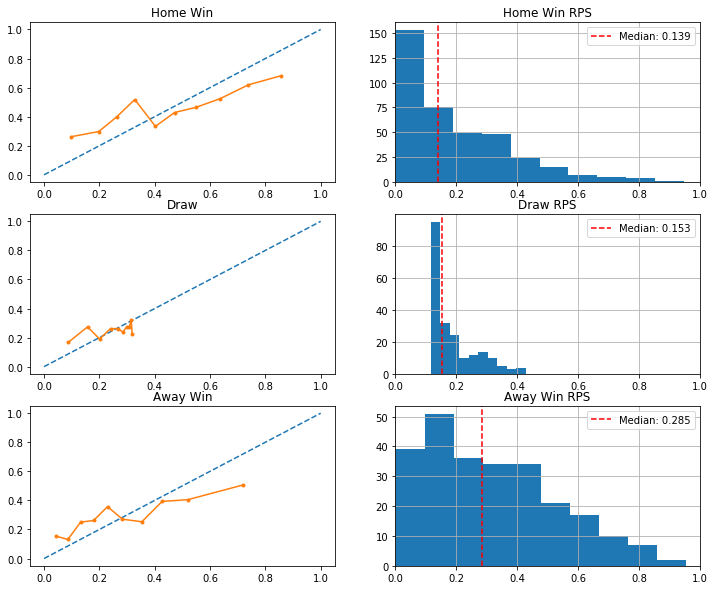


Validation Fold: 2
Average Calibration Error:  0.589
Expected Calibration Error: 0.475
Maximum Calibration Error:  0.923
Number of Instances: 840


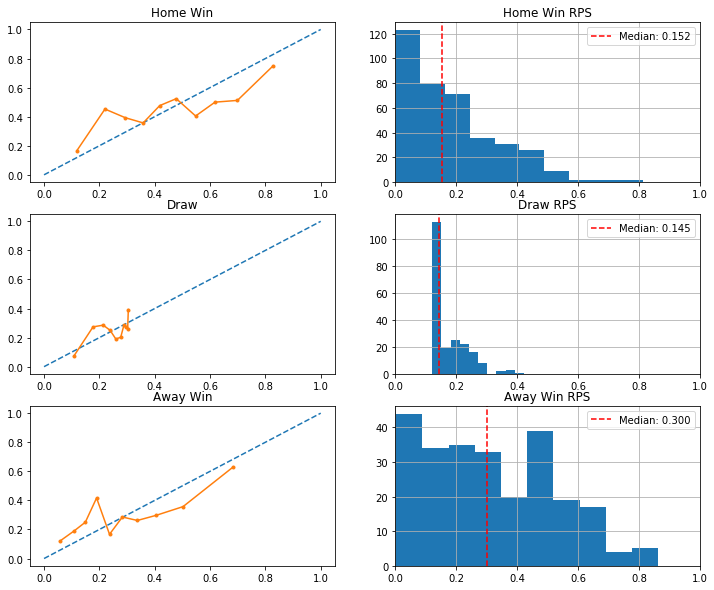

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,1,2,3,model_rps,bookie_rps,baseline_rps,pred_class,pred_result,n_fold
1,germany,bundesliga,2007-2008,hansa-rostock,stuttgart,2007-09-29,2.0,1.0,hwin,13.0,25.0,0.0,0.268657,0.261194,0.470149,0.261955,0.425652,0.312393,0.0,24.0,8.0,2.0,2.00,1.90,2.15,2.04,0.275,0.275,0.45,3.50,3.3,3.60,3.26,2.0,14.0,2.0,0.268657,0.470149,0.261194,0.261955,0.312393,0.425652,0.0,11.0,4.0,1.0,3.60,3.70,3.85,3.41,0.470149,0.268657,0.261194,1,1,0,0,0.228758,0.611111,0.869654,0.869654,0.952228,0.791283,0.733702,0.945584,0.927143,0.620665,0.854213,0.962731,0.250824,0.578336,0.467245,0.171545,0.689112,0.405219,0.212278,0.104961,0.580214,0.529900,0.578336,0.250824,0.318962,0.625450,0.120047,0.373975,0.589552,0.737204,0.214192,0.267384,0.549124,0.549124,0.496330,0.448035,0.427775,0.294124,0.327438,0.626118,0.179687,0.151848,0.434318,0.336893,0.256310,0.462885,0.704503,0.676756,0.209645,0.079409,0.851027,0.796003,0.336893,0.434318,0.545186,0.355301,0.119773,0.126443,0.637420,0.641351,0.017949,0.103631,0.214286,0.2,0.428571,0.052632,0.500000,0.352941,0.071429,0.263158,0.600000,0.407407,0.714286,0.862069,0.533333,0.407407,0.571429,0.259259,0.142857,0.125,0.375,0.222222,0.000000,0.333333,0.333333,0.000000,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423077,0.214286,0.419355,0.133333,0.44,0.285714,0.419355,0.400000,0.60,0.384615,0.633333,0.533333,0.28,0.384615,0.696970,0.133333,0.714286,0.2,0.000000,0.166667,0.333333,0.166667,0.166667,0.166667,0.297633,0.301590,0.400777,0.326971,0.383437,0.189062,3,awin,1
2,germany,bundesliga,2007-2008,karlsruher,dortmund,2007-09-29,3.0,1.0,hwin,4.0,17.0,1.0,0.288958,0.335397,0.375645,0.186414,0.624013,0.189529,0.0,6.0,1.0,1.0,2.50,2.55,2.63,2.48,0.275,0.275,0.45,3.25,3.2,3.32,3.21,6.0,10.0,1.0,0.288958,0.375645,0.335397,0.186414,0.189529,0.624013,0.0,15.0,6.0,0.0,2.80,2.55,2.90,2.67,0.375645,0.288958,0.335397,1,1,0,0,0.228758,0.611111,0.970529,0.970529,0.949220,0.973719,0.872847,0.651179,0.952604,0.966574,0.858307,0.937000,0.344495,0.451016,0.409433,0.352770,0.559936,0.838705,0.252619,0.432274,0.545486,0.581960,0.451016,0.344495,0.382490,0.410793,0.220366,0.066592,0.536812,0.350739,0.250478,0.227840,0.375659,0.375659,0.416164,0.558905,0.595570,0.266097,0.232889,0.460279,0.169025,0.211780,0.642242,0.202291,0.652045,0.448543,0.582615,0.763607,0.101512,0.472390,0.801397,0.637420,0.202291,0.642242,0.170139,0.317623,0.170050,0.064291,0.796003,0.344800,0.078801,0.212321,0.285714,0.2,0.285714,0.368421,0.428571,0.352941,0.428571,0.210526,0.500000,0.333333,0.285714,0.482759,0.566667,0.851852,0.285714,0.740741,0.285714,0.000,0.125,0.111111,0.166667,0.333333,0.333333,0.142857,0.2,0.0,0.0,0.0,0.0,0.6,0.0,0.00,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.846154,0.571429,0.096774,0.133333,0.48,0.214286,0.354839,0.400000,0.56,0.307692,0.033333,0.333333,0.68,0.461538,0.272727,0.333333,0.142857,0.2,0.142857,0.333333,0.166667,0.333333,0.333333,0.333333,0.270974,0.296398,0.432628,0.359323,0

In [32]:
# validate_dfs = []

# rps_adj_scores = []
# bal_acc_scores = []

def run_fit_validate(X, y, X_cal, y_cal, meta_train_val, skf, srs, clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)

        # Probability calibration

#         sig_clf.fit(X_cal, y_cal)
#         sig_validate_preds = sig_clf.predict_proba(X_validate)

        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')


        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        #bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))


        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()
    return validate_dfs

              


n_splits=2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
srs = SelectiveMinMaxScaler(trans_col_name='')

# clf = m.LogisticSE(max_iter=1000, alpha=0)
clf = m.LogisticAT(max_iter=100, alpha=0.0) # Passable
# clf = m.LogisticIT(max_iter=100, alpha=1000) # Think profitable
# clf = LogisticRegression(max_iter=1000)
# clf = GaussianProcessClassifier(max_iter_predict=1000)

dfs = run_fit_validate(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, skf, srs, clf)
dfs[1].head()


In [33]:
joblib.dump(clf, SAMP_MODEL_FP)

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/optimized-model.joblib']

## 8. Simulate Gambling in Test Data

In [34]:
clf = joblib.load(SAMP_MODEL_FP)
clf

LogisticAT(alpha=0.0, max_iter=100, verbose=0)

In [35]:
# sig_clf = joblib.load(SAMP_CAL_FP)
# sig_clf

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


Average Calibration Error:  0.565
Expected Calibration Error: 0.429
Maximum Calibration Error:  0.929
Number of Instances: 471


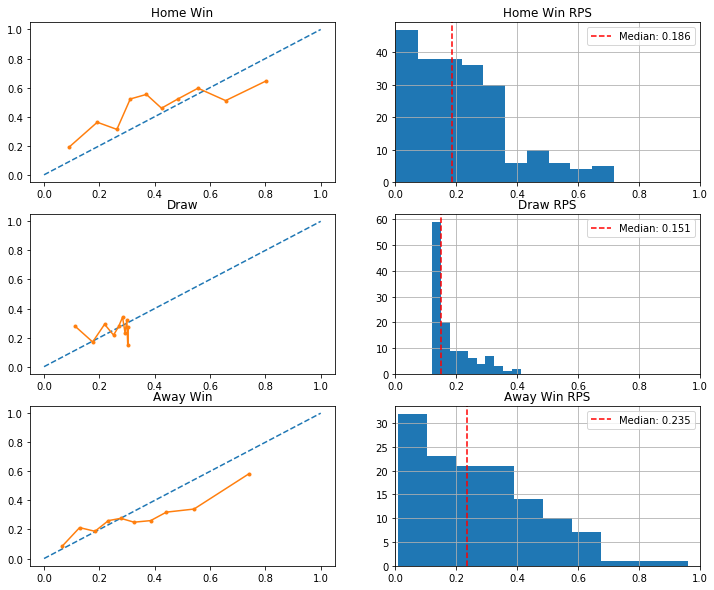

In [36]:
def predict_on_test(X_t, y_t, meta_t, srs, clf):
#     meta_t = meta_held_out_test.copy(deep=True)
#     X_t = X_held_out_test.copy(deep=True)
#     y_t = y_held_out_test.copy(deep=True)

    meta_t.reset_index(drop=True, inplace=True)
    X_t.reset_index(drop=True, inplace=True)
    y_t.reset_index(drop=True, inplace=True)
    
    
    X_t = srs.transform(X_t)
    test_preds = clf.predict_proba(X_t)
    test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
    df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)

    df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
    df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

    df_test = insert_rps(df_test)
    df_test = insert_rps(df_test,
                             prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                             return_col_prefix='bookie')
    df_test = insert_rps(df_test,
                             prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                             return_col_prefix='baseline')
    return df_test


def bet_all_positive_EVs(df_orig, param_dict):
    df = df_orig.copy(deep=True)
    # # Betting Strategy # 1
    # # ## EV > Threshold ##
    EV_threshold = param_dict['EV_threshold']
    mask = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_highest_EV_per_game(df_orig, param_dict):
    # Betting Strategy # 2
    ## EV > Threshold - Bet on Maximum EV for each Game ##
    df = df_orig.copy(deep=True)
    EV_threshold = param_dict['EV_threshold']
    mask1 = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    mask2 = df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
                df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

    mask = np.logical_and(mask1, mask2)
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_single_type_positive_EV(df_orig, param_dict={'EV_threshold': 0.0, 'bet_type': 'hwin'}):    
    # # Betting Strategy # 4
    # ## EV > Threshold - Bet on Maximum EV for each Game, only bet on draws##
    # EV_threshold = 0.1
    df = df_orig.copy(deep=True)
    EV_threshold = param_dict['EV_threshold']
    bet_type = param_dict['bet_type']
    mask1 = (df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    mask2 = df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
                 df[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

    mask = np.logical_and(mask1, mask2)
    if bet_type == 'hwin':
        mask[:,1] = 0
        mask[:,2] = 0
    if bet_type == 'draw':
        mask[:,0] = 0
        mask[:,2] = 0
    if bet_type == 'awin':
        mask[:,0] = 0
        mask[:,1] = 0
    df[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)
    return df


def bet_EV_threshold_odds_threshold(df_orig, params_dict):
    df = df_orig.copy(deep=True)
    # # Betting Strategy # 5
    # # ## EV > EV_Threshold - Odds < odds_threshold ##
    # EV_threshold = 0.1
    # odds_threshold = 6.0

    # mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
    # mask2 = (df_test[['hwinOddsMean', 'drawOddsMean', 'awinOddsMean']] <= odds_threshold).values

    # mask = np.logical_and(mask1, mask2)

    # df_test['hwin_bet'] = 0 ; df_test['draw_bet'] = 0 ; df_test['awin_bet'] = 0
    # df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = mask
    return df


def do_bets(df_orig):
    df = df_orig.copy(deep=True)

    # Do betting
    for n, bet_type in zip([1, 2, 3], ['hwin', 'draw', 'awin']):
        # Condition 1 - Place bet and bet wins
        # Condition 2 - Place bet and bet loses
        conditions = [(df[bet_type + '_bet'] == 1) & (df['ordinal_result_' + str(n)] == 1),
                      (df[bet_type + '_bet'] == 1) & (df['ordinal_result_' + str(n)] == 0)]
        # Choices - 1 - Winnings; 2 - Loss
        choices = [(df[bet_type + 'OddsMax']-1), -1]
        # Default - no bet placed
        df[bet_type +'_rets'] = np.select(conditions, choices, default=0)
        
    # Works if placing a single bet [per game]
    def get_placed_bet(row):
        if row[0]:
            return 'hwin_bet'
        elif row[1]:
            return 'draw_bet'
        elif row[2]:
            return 'awin_bet'
        else:
            return 'no_bet'
    df['placed_bet'] = df[['hwin_bet', 'draw_bet', 'awin_bet']].apply(get_placed_bet, axis=1)

    # Get total Return per Game
    df['game_ret'] = df[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)
    
    return df
        
        
def calculate_EVs(df_orig):
    df = df_orig.copy(deep=True)
    df['hwin_unit_EV'] = (df[1]* (df['hwinOddsMean']-1)) + ((1- df[1]) * -1)
    df['draw_unit_EV'] = (df[2]* (df['drawOddsMean']-1)) + ((1- df[2]) * -1)
    df['awin_unit_EV'] = (df[3]* (df['awinOddsMean']-1)) + ((1- df[3]) * -1)
    return df
    
    
def simulate_betting(df,
                     strategy='highest_EV_per_game',
                     param_dict={'EV_threshold': 0.0}):
    
    df = calculate_EVs(df)
    
    if strategy == 'highest_EV_per_game':
        df = bet_highest_EV_per_game(df, param_dict)
    if strategy == 'all_positive_EVs':
        df = bet_all_positive_EVs(df, param_dict)
    if strategy == 'single_bet_type_positive_EV':
        df = bet_single_bet_positive_EV(df, param_dict)
        
    df = do_bets(df)
    return df


clf = joblib.load(SAMP_MODEL_FP)
clf


df = predict_on_test(X_held_out_test, y_held_out_test, meta_held_out_test, srs, clf)

get_model_diagnosis(df, add_baseline=True)
plt.show();

In [37]:
df = simulate_betting(df)

df.to_csv(SAVE_FP, index=False)

df.head(15)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,sc-freiburg,augsburg,2016-10-22,2.0,1.0,hwin,1.0,10.0,0.0,0.288740,0.453735,0.257525,0.272061,0.576203,0.151736,0.0,14.0,6.0,0.0,3.70,3.50,3.79,3.53,0.275,0.275,0.45,3.30,3.30,3.41,3.29,0.0,7.0,0.0,0.288740,0.257525,0.453735,0.272061,0.151736,0.576203,0.0,12.0,5.0,1.0,2.10,2.15,2.25,2.16,0.257525,0.288740,0.453735,1,1,0,0,0.228758,0.611111,0.969449,0.969449,0.800847,0.934080,0.857703,0.962145,0.627522,0.816435,0.165755,0.934148,0.493880,0.291880,0.643012,0.524265,0.464159,0.370136,0.686507,0.202787,0.927918,0.377514,0.291880,0.493880,0.169468,0.266465,0.330760,0.400868,0.154708,0.596531,0.031459,0.411141,0.572332,0.572332,0.264754,0.672816,0.465513,0.317854,1.940013,0.873673,-0.013167,0.018282,0.592127,0.160888,0.859357,0.437569,0.506445,0.287293,-0.001588,0.402654,0.941527,7.697422e-03,0.160888,0.592127,0.026600,0.275297,0.312008,0.484259,-2.681978e-10,0.219757,0.000200,9.872082e-01,0.214286,0.30,0.357143,0.473684,0.214286,0.176471,0.214286,0.368421,0.266667,0.333333,0.321429,0.310345,0.400000,0.074074,0.750000,0.444444,0.142857,0.125,0.125,0.111111,0.000000,0.111111,0.166667,0.142857,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.192308,0.142857,0.225806,0.333333,0.44,0.428571,0.225806,0.200000,0.12,0.153846,0.466667,0.400000,0.28,0.384615,0.515152,0.266667,0.428571,0.4,0.428571,0.666667,0.333333,0.333333,0.500000,0.166667,0.373728,0.304265,0.322006,1,hwin,0.247952,0.182362,0.189062,-0.192747,0.001033,0.136682,False,False,True,0.00,0.0,-1.00,awin_bet,-1.00
1,germany,bundesliga,2016-2017,schalke,mainz,2016-10-23,3.0,0.0,hwin,3.0,16.0,0.0,0.263607,0.486660,0.249733,0.224402,0.501203,0.274390,0.0,10.0,4.0,3.0,3.80,3.80,4.06,3.76,0.275,0.275,0.45,3.60,3.75,3.80,3.60,3.0,16.0,1.0,0.263607,0.249733,0.486660,0.224402,0.274390,0.501203,0.0,11.0,5.0,2.0,1.95,2.00,2.03,1.97,0.249733,0.263607,0.486660,1,1,0,0,0.235294,0.611111,0.844563,0.844563,0.850267,0.753226,0.924321,0.924078,0.887354,0.958944,0.916751,0.938085,0.535443,0.281382,0.563478,0.143464,0.277867,0.357650,0.283136,0.494145,0.348908,0.322735,0.281382,0.535443,0.242302,0.661424,0.516239,0.422635,0.523040,0.297579,0.446041,0.458988,0.462892,0.462892,0.535426,0.244844,0.703389,0.307972,1.940013,0.466534,0.127116,1.233933,0.513511,0.295259,0.294155,0.060114,0.275297,0.680846,-0.001588,0.087233,0.868663,-2.681978e-10,0.295259,0.513511,0.486695,0.835954,0.445152,0.111746,-2.681978e-10,0.707762,0.041882,-2.727282e-10,0.214286,0.35,0.285714,0.157895,1.000000,0.352941,0.428571,0.421053,0.100000,0.518519,0.357143,0.275862,0.333333,0.259259,0.285714,0.444444,0.000000,0.250,0.125,0.444444,0.333333,0.222222,0.166667,0.142857,0.0,0.2,0.0,0.0,0.0,0.4,0.2,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269231,0.142857,0.290323,0.

pred hwin: 29.7 on 176 bets
pred draw: 23.13 on 35 bets
pred awin: 5.909999999999998 on 238 bets
449 bets returning 58.74000000000001 over 471 games
Overall Return: 0.131

On Sided t Test Against against Mean = 0:
	t_stat:	1.678
	p_val:	0.047


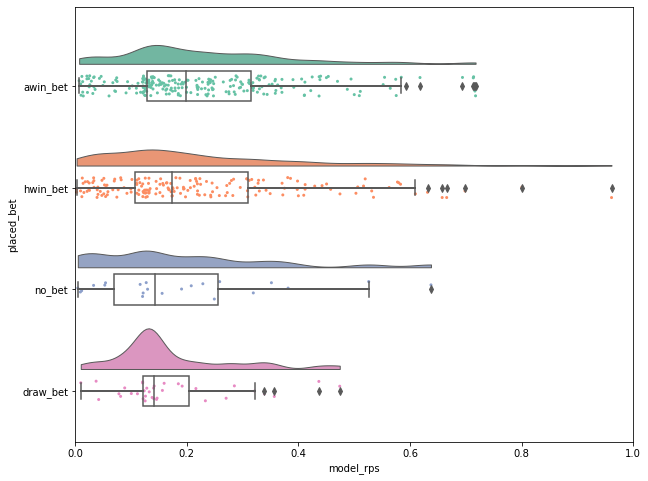

In [38]:
import ptitprince as pt
from scipy.stats import ttest_1samp

def get_betting_diagnosis(df):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
    ax.set_xlim(0.0, 1.0)
    
    bet_rets = pd.concat([df['hwin_rets'], df['draw_rets'], df['awin_rets']], axis=0)
    bet_rets = bet_rets[bet_rets != 0].values
    res = ttest_1samp(bet_rets, 0)
    t_stat = res[0]
    p_val = res[1]/2
    
    # Swarm Plot on Probabilities her
    # sns.catplot(x="day", y="total_bill", kind="swarm", data=tips);
    
    n_bets = df[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()
    print(f'pred hwin: {df["hwin_rets"].sum()} on {df["hwin_bet"].sum()} bets')
    print(f'pred draw: {df["draw_rets"].sum()} on {df["draw_bet"].sum()} bets')
    print(f'pred awin: {df["awin_rets"].sum()} on {df["awin_bet"].sum()} bets')
    print(f'{n_bets} bets returning {df["game_ret"].sum()} over {len(df)} games')
    print(f'Overall Return: {df["game_ret"].sum()/n_bets:.3f}')
    print()
    print(f'On Sided t Test Against against Mean = 0:\n\tt_stat:\t{t_stat:.3f}\n\tp_val:\t{p_val:.3f}')
    return fig, ax


get_betting_diagnosis(df)
plt.show();